In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import utils
from scipy.optimize import least_squares, curve_fit, minimize, differential_evolution
import numpy as np
import os
from tqdm import tqdm
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from DataLoader import DataLoader
import datetime as dt
import joblib as joblib
import Calibration as calibration

import warnings
warnings.filterwarnings("ignore")

In [3]:
# def sigma_market(ivol_data, expiry: int):
#     exp_vix2_mkt = vix2(ivol_data, expiry=expiry) * utils.DELTA / 10**4
#     exp_vix4_mkt = vix4(ivol_data, expiry=expiry) * utils.DELTA**2 / 10**8
    # return utils.sigma_lognormal(exp_vix2_mkt, exp_vix4_mkt)

def sigma_jacquier(curve: utils.VarianceCurve, volvol: float, hurst: utils.Hurst, T: float):
    exp_vix2_jac = utils.expected_vix_sq(curve)
    exp_vix4_jac = utils.moment2_vix_sq(curve, delta=utils.DELTA, volvol=volvol, hurst=hurst, T=T)
    return utils.sigma_lognormal(exp_vix2_jac, exp_vix4_jac)

# def sigma_jim(texp, eta: float, hurst: utils.Hurst):
#     return eta**2 * texp**hurst.h2 * utils.f_supH(utils.DELTA / texp, hurst)

In [3]:
def _const_curve(t):
    return np.full(len(t), .234**2) if isinstance(t, np.ndarray) else .234**2

xi_1 = utils.VarianceCurve(_const_curve)

# One day example

In [6]:
params = pl.read_parquet(f"params_20060224_20100101.parquet").rename({'__index_level_0__': 'Date'})

In [7]:
params

H,eta,Date
f64,f64,datetime[ns]
0.060874,1.24035,2006-02-24 00:00:00
0.019416,null,2006-02-27 00:00:00
0.103102,1.246258,2006-02-28 00:00:00
0.21886,1.309458,2006-03-01 00:00:00
0.031852,null,2006-03-02 00:00:00
…,…,…
0.204327,1.488689,2009-12-24 00:00:00
0.248004,1.485507,2009-12-28 00:00:00
0.300411,1.487227,2009-12-29 00:00:00


In [8]:
loader = DataLoader("./data", "csv")
df = loader.load_dates("20060302", "20060303").to_pandas().set_index('Date')

In [9]:
# Parameters
H = utils.Hurst(0.07)
eta = 1.9
volvol = eta * np.sqrt(H.h2) / (utils.c_h(H) * 2)

In [10]:
single_texp = df.groupby('Texp')['Texp'].count()
single_texp = set(single_texp[single_texp == 1].index)
df = df[~df['Texp'].isin(single_texp)]

In [11]:
df

,,Expiry,Texp,Strike,Bid,Ask,Fwd,CallMid
Date,,,,,,,,
2006-03-02,2,20060322,0.054795,12.5,0.675188,0.719842,12.127780,0.625
2006-03-02,3,20060322,0.054795,15.0,0.699282,0.988688,12.127780,0.200
2006-03-02,6,20060419,0.131393,10.0,0.461262,0.612153,12.923939,3.000
2006-03-02,7,20060419,0.131393,12.5,0.441717,0.868850,12.923939,1.450
2006-03-02,8,20060419,0.131393,15.0,0.511968,0.883532,12.923939,0.600
2006-03-02,10,20060419,0.131393,20.0,0.660334,1.373205,12.923939,0.425
2006-03-02,12,20060517,0.208105,12.5,0.536310,0.582372,13.693846,2.250
2006-03-02,13,20060517,0.208105,15.0,0.610889,0.755612,13.693846,1.175
2006-03-02,14,20060517,0.208105,17.5,0.330773,0.813087,13.693846,0.450


In [12]:
exp_dates = df['Expiry'].unique()
texp_array = df['Texp'].unique()

In [13]:
df

,,Expiry,Texp,Strike,Bid,Ask,Fwd,CallMid
Date,,,,,,,,
2006-03-02,2,20060322,0.054795,12.5,0.675188,0.719842,12.127780,0.625
2006-03-02,3,20060322,0.054795,15.0,0.699282,0.988688,12.127780,0.200
2006-03-02,6,20060419,0.131393,10.0,0.461262,0.612153,12.923939,3.000
2006-03-02,7,20060419,0.131393,12.5,0.441717,0.868850,12.923939,1.450
2006-03-02,8,20060419,0.131393,15.0,0.511968,0.883532,12.923939,0.600
2006-03-02,10,20060419,0.131393,20.0,0.660334,1.373205,12.923939,0.425
2006-03-02,12,20060517,0.208105,12.5,0.536310,0.582372,13.693846,2.250
2006-03-02,13,20060517,0.208105,15.0,0.610889,0.755612,13.693846,1.175
2006-03-02,14,20060517,0.208105,17.5,0.330773,0.813087,13.693846,0.450


In [3]:
sigma = np.array([
    calibration.sigma_market(df, exp) for exp in exp_dates
])

NameError: name 'exp_dates' is not defined

In [16]:
# def calibration(texps, h, nu):
#     hurst = utils.Hurst(h)

#     sigma_model = np.array([
#         sigma_jacquier(xi_1, nu, hurst, texp) for texp in texps
#     ])
#     return sigma_model


# def calibration_h(texps, h):
#     hurst = utils.Hurst(h)

#     sigma_model = np.array([
#         sigma_jacquier(xi_1, volvol, hurst, texp) for texp in texps
#     ])
#     return sigma_model

In [17]:
def calibration_jim(texps, h, _eta):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        calibration.sigma_jim(texp, _eta, hurst) for texp in texps
    ])
    return sigma_model


def calibration_h_jim(texps, h):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        calibration.sigma_jim(texp, eta, hurst) for texp in texps
    ])
    return sigma_model

In [18]:
params, _ = curve_fit(
    calibration_jim, texp_array, sigma,
    p0=[0.07, eta],
    bounds=([0., 0.], [1., np.inf])
)

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [19]:
params_h, _ = curve_fit(
    calibration_h_jim, texp_array, sigma,
    p0=[0.07],
    bounds=(0., 1.)
)

In [20]:
print(params)
print([params_h.item(), eta])

shape: (971, 3)
┌──────────┬──────────┬─────────────────────┐
│ H        ┆ eta      ┆ Date                │
│ ---      ┆ ---      ┆ ---                 │
│ f64      ┆ f64      ┆ datetime[ns]        │
╞══════════╪══════════╪═════════════════════╡
│ 0.060874 ┆ 1.24035  ┆ 2006-02-24 00:00:00 │
│ 0.019416 ┆ null     ┆ 2006-02-27 00:00:00 │
│ 0.103102 ┆ 1.246258 ┆ 2006-02-28 00:00:00 │
│ 0.21886  ┆ 1.309458 ┆ 2006-03-01 00:00:00 │
│ 0.031852 ┆ null     ┆ 2006-03-02 00:00:00 │
│ …        ┆ …        ┆ …                   │
│ 0.204327 ┆ 1.488689 ┆ 2009-12-24 00:00:00 │
│ 0.248004 ┆ 1.485507 ┆ 2009-12-28 00:00:00 │
│ 0.300411 ┆ 1.487227 ┆ 2009-12-29 00:00:00 │
│ 0.249737 ┆ 1.508325 ┆ 2009-12-30 00:00:00 │
│ 0.298423 ┆ 1.450311 ┆ 2009-12-31 00:00:00 │
└──────────┴──────────┴─────────────────────┘
[0.031851525723431806, 1.9]


In [21]:
# sigma_joint = calibration_jim(texp_array, *params)
sigma_h = calibration_h_jim(texp_array, params_h.item())
sigma_hat_0 = calibration_jim(texp_array, H.h, eta)

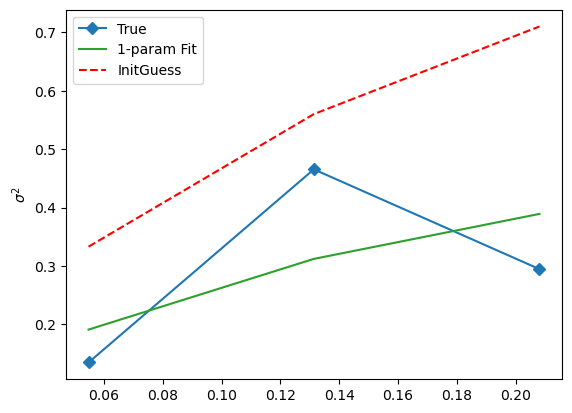

In [22]:
plt.plot(texp_array, sigma, marker='D', label='True', color='C0')
# plt.plot(texp_array, sigma_joint, label='2-param Fit', color='C1')
plt.plot(texp_array, sigma_h, label='1-param Fit', color='C2')
plt.plot(texp_array, sigma_hat_0, color='red', ls='--', label='InitGuess')
plt.ylabel(r"$\sigma^2$")
plt.legend()
plt.show()

In [ ]:
[r2_score(sigma, pred) for pred in (sigma_joint, sigma_h)]

[0.9031053857510027, 0.7259560461363841]

# Everyday I'm hustling

In [ ]:
start, end = "20230301", "20230331"

In [16]:
loader = DataLoader("./data", "csv")
df = loader.load_dates(start, end).sort('Date')[:, 1:]

df = loader.filter_maturities(df, 5)

In [17]:
dates = df['Date'].unique().to_list()

In [18]:
# Parameters
H = utils.Hurst(0.07)
eta = 1.9
volvol = eta * np.sqrt(H.h2) / (utils.c_h(H) * 2)

def calibration_jim(texps, h, _eta):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        calibration.sigma_jim(texp, _eta, hurst) for texp in texps
    ])
    return sigma_model


def calibration_h_jim(texps, h):
    hurst = utils.Hurst(h)
    sigma_model = np.array([
        calibration.sigma_jim(texp, eta, hurst) for texp in texps
    ])
    return sigma_model

In [57]:
def calibrate_one_day_lbfgs(dd):
    _df = df.filter(pl.col('Date') == dd).to_pandas().set_index('Date')
    if _df.empty:
        return np.array([np.nan, np.nan])
    # address expirations with single obs
    single_texp = _df.groupby('Texp')['Texp'].count()
    single_texp = set(single_texp[single_texp == 1].index)
    _df = _df[~_df['Texp'].isin(single_texp)]
    
    exp_dates = _df['Expiry'].unique()
    texp_array = _df['Texp'].unique()

    # true values
    sigma = np.array([
        calibration.sigma_market(_df, exp) for exp in exp_dates
    ])

    # calibrate - we try 2-parameter calibration and if it fails
    # we just fit H
    obj = lambda x: np.sum((sigma - calibration_jim(texp_array, x[0], x[1]))**2)
    # options = {'eps': 1e-7}
    opt = minimize(
        obj, np.array([0.07, eta]),
        method='L-BFGS-B',
        bounds=((0., 1.), (0., None)),
        # options=options
    )
    if opt.success:
        params = opt.x
        params = np.concatenate((opt.x, [0.0]))
        loss = opt.fun
    else:
        print(f"CAPRA!!!!! NON SAI FARE NULLA! ({dd})")
    # params, _ = curve_fit(
    #     calibration_jim, texp_array, sigma,
    #     p0=[0.07, eta],
    #     bounds=([0., 0.], [1., np.inf])
    # )
        obj = lambda x: np.sum((sigma - calibration_h_jim(texp_array, x[0]))**2)
        opt = minimize(
            obj, np.array([0.07]),
            method='L-BFGS-B',
            bounds=[(0., 1.)]
        )
        if not opt.success:
            #print(f"CAPRA!!!!! NON SAI FARE PROPRIO NULLA! ({dd})rrr")
            arr = np.empty(2) * np.nan
            params = np.concatenate((arr, [2.0]))
            loss = np.inf
        # params, _ = curve_fit(
        #     calibration_h_jim, texp_array, sigma,
        #     p0=[0.07],
        #     bounds=(0., 1.)
        # )
        else:
            params = np.concatenate((opt.x, [np.nan], [1.0]))
            loss = opt.fun
    
    return params, loss
    

def calibrate_one_day_de(dd):
    _df = df.filter(pl.col('Date') == dd).to_pandas().set_index('Date')
    if _df.empty:
        return np.array([np.nan, np.nan])
    # address expirations with single obs
    single_texp = _df.groupby('Texp')['Texp'].count()
    single_texp = set(single_texp[single_texp == 1].index)
    _df = _df[~_df['Texp'].isin(single_texp)]
    
    exp_dates = _df['Expiry'].unique()
    texp_array = _df['Texp'].unique()

    # true values
    sigma = np.array([
        calibration.sigma_market(_df, exp) for exp in exp_dates
    ])

    # calibrate - we try 2-parameter calibration and if it fails
    # we just fit H
    obj = lambda x: np.sum((sigma - calibration_jim(texp_array, x[0], x[1]))**2)
    # options = {'eps': 1e-7}
    opt = differential_evolution(
        obj, x0=np.array([0.07, eta]),
        bounds=((0., 1.), (0., 1000.)),
        # options=options
    )
    if opt.success:
        params = opt.x
        params = np.concatenate((opt.x, [0.0]))
        loss = opt.fun
    else:
        print(f"CAPRA!!!!! NON SAI FARE NULLA! ({dd})")
        obj = lambda x: np.sum((sigma - calibration_h_jim(texp_array, x[0]))**2)
        opt = differential_evolution(
            obj, x0=np.array([0.07]),
            bounds=[(0., 1.)]
        )
        if not opt.success:
            #print(f"CAPRA!!!!! NON SAI FARE PROPRIO NULLA! ({dd})rrr")
            arr = np.empty(2) * np.nan
            params = np.concatenate((arr, [2.0]))
            loss = np.inf
        # params, _ = curve_fit(
        #     calibration_h_jim, texp_array, sigma,
        #     p0=[0.07],
        #     bounds=(0., 1.)
        # )
        else:
            params = np.concatenate((opt.x, [np.nan], [1.0]))
            loss = opt.fun
    
    return params, loss


def calibrate_one_day_lstsq(dd):
    _df = df.filter(pl.col('Date') == dd).to_pandas().set_index('Date')
    if _df.empty:
        return np.array([np.nan, np.nan])
    # address expirations with single obs
    single_texp = _df.groupby('Texp')['Texp'].count()
    single_texp = set(single_texp[single_texp == 1].index)
    _df = _df[~_df['Texp'].isin(single_texp)]
    
    exp_dates = _df['Expiry'].unique()
    texp_array = _df['Texp'].unique()

    # true values
    sigma = np.array([
        calibration.sigma_market(_df, exp) for exp in exp_dates
    ])

    # calibrate - we try 2-parameter calibration and if it fails
    # we just fit H
    try:
        params, _ = curve_fit(
            calibration_jim, texp_array, sigma,
            p0=[0.07, eta],
            bounds=([0., 0.], [1., np.inf])
        )
        loss = np.sum((sigma - calibration_jim(texp_array, *params)) ** 2)
    except RuntimeError:
        print(f"CAPRA!!!!! NON SAI FARE NULLA! ({dd})")
        try:
            params, _ = curve_fit(
                calibration_h_jim, texp_array, sigma,
                p0=[0.07], bounds=([0.], [1.])
            )
            loss = np.sum((sigma - calibration_h_jim(texp_array, *params)) ** 2)
            params = np.concatenate((params, [np.nan]))
        except RuntimeError:
            print(f"CAPRAAAAAAAAAAAAAAAAAjuhyt ({dd})")
            params = np.empty(2) * np.nan
            loss = np.inf
    
    return params, loss
    

In [58]:
params_lbfgs = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(calibrate_one_day_lbfgs)(dd) for dd in dates
)

loss_lbfgs = [x[1] for x in params_lbfgs]
params_lbfgs = [x[0] for x in params_lbfgs]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  callIntegral, _ = quad(
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discon

CAPRA!!!!! NON SAI FARE NULLA! (2023-03-21 00:00:00)


/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  callIntegral, _ = quad(
[Parallel(n_jobs=-1)]: Done  16 out of  22 | elapsed:   16.6s remaining:    6.2s
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, d

In [59]:
params_devo = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(calibrate_one_day_de)(dd) for dd in dates
)

loss_devo = [x[1] for x in params_devo]
params_devo = [x[0] for x in params_devo]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  callIntegral, _ = quad(
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discon

In [25]:
params_lstsq = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(calibrate_one_day_lstsq)(dd) for dd in dates
)

loss_lstsq = [x[1] for x in params_lstsq]
params_lstsq = [x[0] for x in params_lstsq]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  callIntegral, _ = quad(
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discon

CAPRA!!!!! NON SAI FARE NULLA! (2023-03-15 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2023-03-14 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2023-03-13 00:00:00)


[Parallel(n_jobs=-1)]: Done  10 out of  22 | elapsed:   12.1s remaining:   14.5s


CAPRA!!!!! NON SAI FARE NULLA! (2023-03-16 00:00:00)


/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  callIntegral, _ = quad(
[Parallel(n_jobs=-1)]: Done  13 out of  22 | elapsed:   12.7s remaining:    8.8s


CAPRA!!!!! NON SAI FARE NULLA! (2023-03-22 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2023-03-21 00:00:00)


/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  callIntegral, _ = quad(


CAPRA!!!!! NON SAI FARE NULLA! (2023-03-17 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2023-03-20 00:00:00)


/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  callIntegral, _ = quad(
/Users/niccolofabbri/Desktop/CLASSES/Capstone_BergomiVIX/Calibration.py:71: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and callin

CAPRA!!!!! NON SAI FARE NULLA! (2023-03-27 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2023-03-28 00:00:00)
CAPRA!!!!! NON SAI FARE NULLA! (2023-03-24 00:00:00)


[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:   17.2s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   17.5s finished


# Check params

In [61]:
params_lbfgs = pd.DataFrame(params_lbfgs, index=dates, columns=['H', 'eta', 'err_code'])
params_devo = pd.DataFrame(params_devo, index=dates, columns=['H', 'eta', 'err_code'])
params_lstsq = pd.DataFrame(params_lstsq, index=dates, columns=['H', 'eta'])

In [62]:
loss_lbfgs = pd.Series(loss_lbfgs, index=dates)
loss_devo = pd.Series(loss_devo, index=dates)
loss_lstsq = pd.Series(loss_lstsq, index=dates)

loss = pd.concat([
    loss_lbfgs.rename('LBFGS'), loss_devo.rename('DiffEvo'), loss_lstsq.rename('lstsq')
    ], axis=1)

In [65]:
fails = params_lstsq['eta'].isna()

In [73]:
dict(zip(loss.columns.to_list(), 'v^<'))

{'LBFGS': 'v', 'DiffEvo': '^', 'lstsq': '<'}

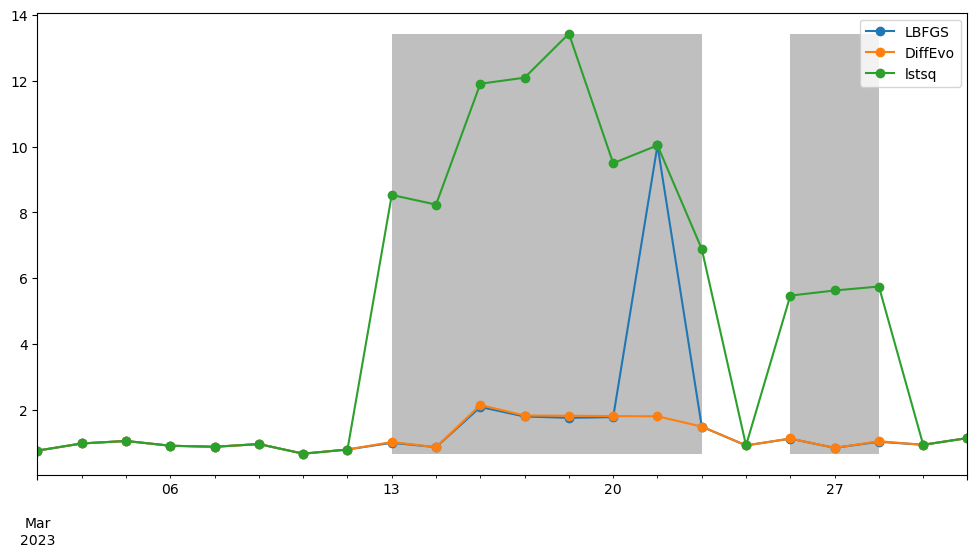

In [78]:
ax = loss.plot(figsize=(12, 6), marker='o')
ax.fill_between(dates, loss.min().min(), loss.max().max(), fails, alpha=.5, facecolor='gray')
plt.show()

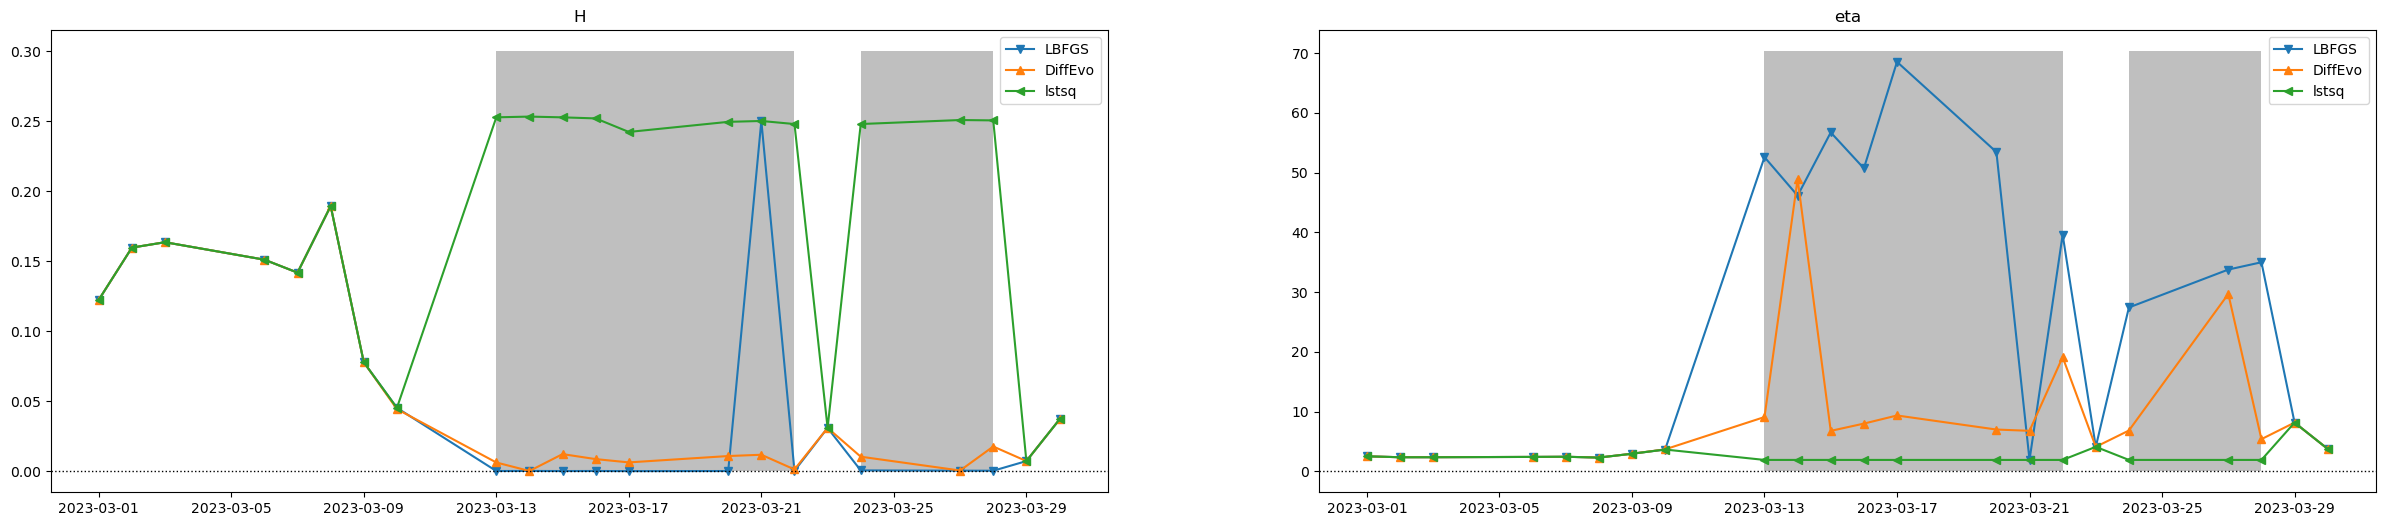

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
for i, param in enumerate(('H' ,'eta')):
    axs[i].plot(dates, params_lbfgs[param].fillna(1.9), label='LBFGS', marker='v')
    axs[i].plot(dates, params_devo[param].fillna(1.9), label='DiffEvo', marker='^')
    axs[i].plot(dates, params_lstsq[param].fillna(1.9), label='lstsq', marker='<')
    axs[i].fill_between(dates, 0., .3 + i*70, fails, alpha=.5, facecolor='gray')
    axs[i].axhline(0, ls=':', lw=1, color='black')
    axs[i].legend()
    axs[i].set_title(param)
plt.show()

In [80]:
dd_good = dates[0]
dd_lbfgs = dt.datetime(2023, 3, 17)
dd_fail = dt.datetime(2023, 3, 21)

sub_dates = [dd_good, dd_lbfgs, dd_fail]

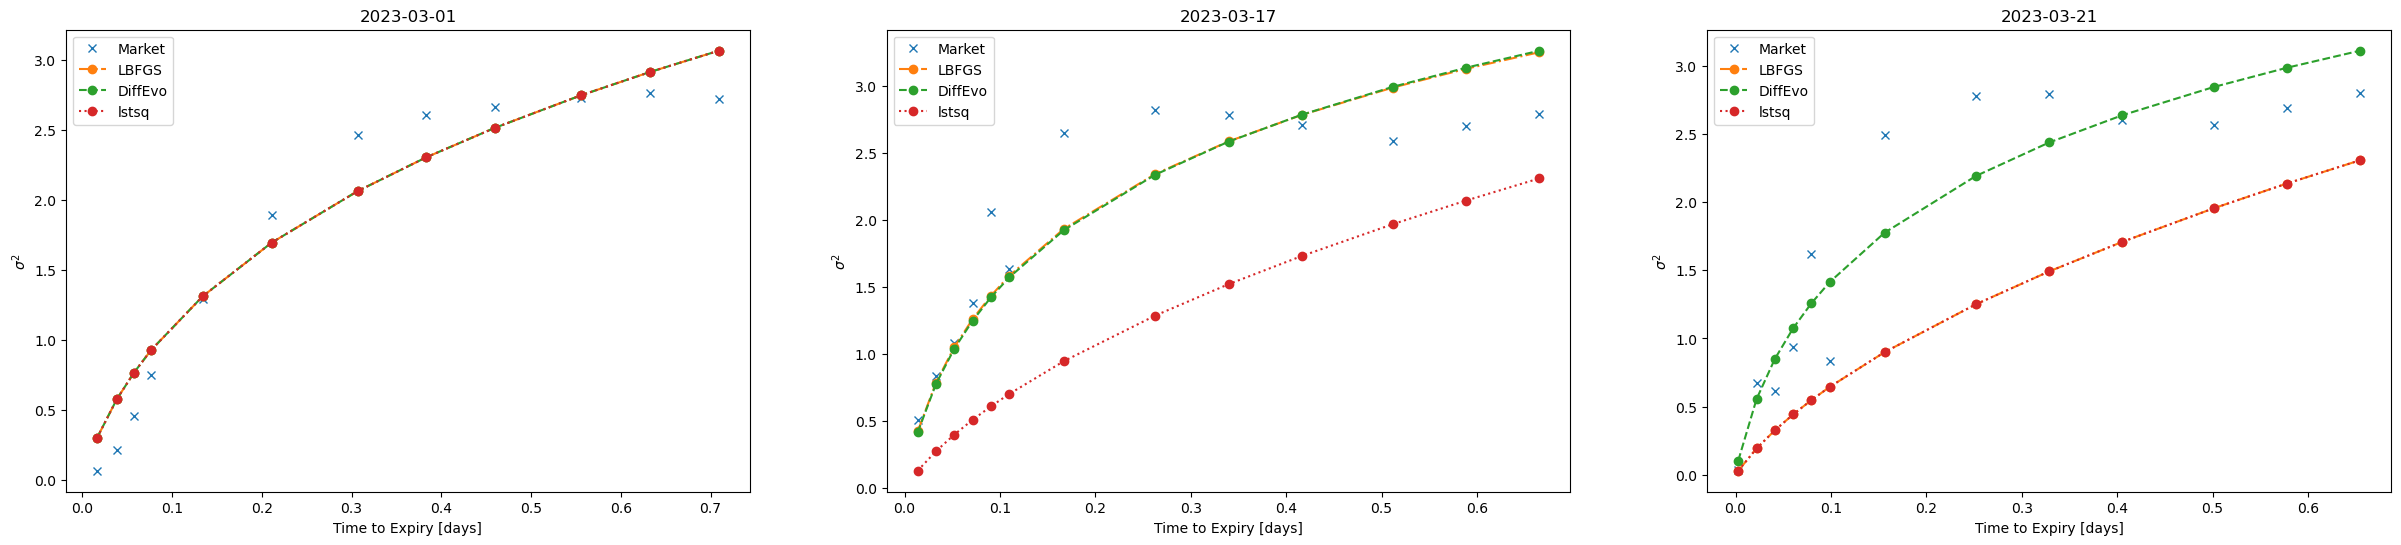

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(30, 6))
for i, d in enumerate(sub_dates):
    _df = df.filter(pl.col('Date') == d).to_pandas().set_index('Date')
    exp_dates = _df['Expiry'].unique()
    texp_array = _df['Texp'].unique()

    sigma = np.array([
        calibration.sigma_market(_df, exp) for exp in exp_dates
    ])

    sigma_lbfgs = calibration_jim(texp_array, *params_lbfgs.fillna(1.9).loc[d, ['H', 'eta']])
    sigma_devo = calibration_jim(texp_array, *params_devo.fillna(1.9).loc[d, ['H', 'eta']])
    sigma_lstsq = calibration_jim(texp_array, *params_lstsq.fillna(1.9).loc[d])

    axs[i].plot(texp_array, sigma, label='Market', lw=0, marker='x')
    axs[i].plot(texp_array, sigma_lbfgs, label='LBFGS', marker='o', ls='-.')
    axs[i].plot(texp_array, sigma_devo, label='DiffEvo', marker='o', ls='--')
    axs[i].plot(texp_array, sigma_lstsq, label='lstsq', marker='o', ls=':')
    axs[i].legend()
    axs[i].set_xlabel('Time to Expiry [days]'); axs[i].set_ylabel(r"$\sigma^2$")
    axs[i].set_title(f'{d.strftime("%Y-%m-%d")}')

plt.show()

# Analyze

In [15]:
params_now = pd.DataFrame(calibrated_params, columns=['H', 'eta', 'err_code'], index=dates)

In [16]:
params_now

,H,eta,err_code
2006-02-27,0.001504,6.514187,0.0
2006-02-28,0.103098,1.246271,0.0
2006-03-01,0.218843,1.309456,0.0
2006-03-02,0.000359,16.490253,0.0
2006-03-03,0.108857,1.214881,0.0
...,...,...,...
2006-08-24,0.118224,1.631717,0.0
2006-08-25,0.135370,1.568637,0.0
2006-08-28,0.107451,1.641882,0.0
2006-08-29,0.070179,1.915152,0.0


In [17]:
pd.read_parquet('params_20060224_20230831.parquet')

,H,eta,err_code
2006-02-24,0.060878,1.240324,0.0
2006-02-27,0.001504,6.514187,0.0
2006-02-28,0.103098,1.246271,0.0
2006-03-01,0.218843,1.309456,0.0
2006-03-02,0.000359,16.490253,0.0
...,...,...,...
2023-08-24,0.003983,12.433389,0.0
2023-08-25,0.021462,5.520464,0.0
2023-08-28,0.029094,4.848911,0.0
2023-08-29,0.028095,4.936410,0.0


In [ ]:
params = pd.DataFrame(calibrated_params, columns=['H', 'eta', 'err_code'], index=dates)
params.describe()

,H,eta,err_code
count,4408.000000,4164.000000,4408.000000
mean,0.057056,11.965059,0.055354
std,0.080082,11.437823,0.228696
min,0.000132,1.020791,0.000000
25%,0.000658,2.188385,0.000000
50%,0.010839,7.362638,0.000000
75%,0.093568,19.597712,0.000000
max,1.000000,105.383372,1.000000


In [17]:
params.loc[params['err_code']==1]

,H,eta,err_code
2006-07-11,0.061384,NaN,1.0
2006-07-21,0.088801,NaN,1.0
2006-07-24,0.092334,NaN,1.0
2006-12-13,0.040839,NaN,1.0
2006-12-29,0.047914,NaN,1.0
...,...,...,...
2022-11-25,0.258003,NaN,1.0
2022-12-06,0.274256,NaN,1.0
2023-03-13,0.252817,NaN,1.0
2023-05-24,0.252348,NaN,1.0


In [ ]:
params.to_c('')

In [152]:
params.fillna(eta).describe()

,H,eta,err_code
count,4409.000000,4409.000000,4409.000000
mean,0.052308,19.590349,0.024269
std,0.077726,20.496265,0.153899
min,0.000045,1.020791,0.000000
25%,0.000212,2.122018,0.000000
50%,0.002851,9.107274,0.000000
75%,0.084064,33.907436,0.000000
max,1.000000,134.606600,1.000000


In [89]:
params.dropna().describe()

,H,eta,err_code
count,213.000000,213.000000,213.0
mean,0.094763,8.363122,0.0
std,0.086907,11.486874,0.0
min,0.000076,1.050331,0.0
25%,0.001039,1.317468,0.0
50%,0.092759,1.635737,0.0
75%,0.156960,13.627962,0.0
max,0.321317,43.621108,0.0


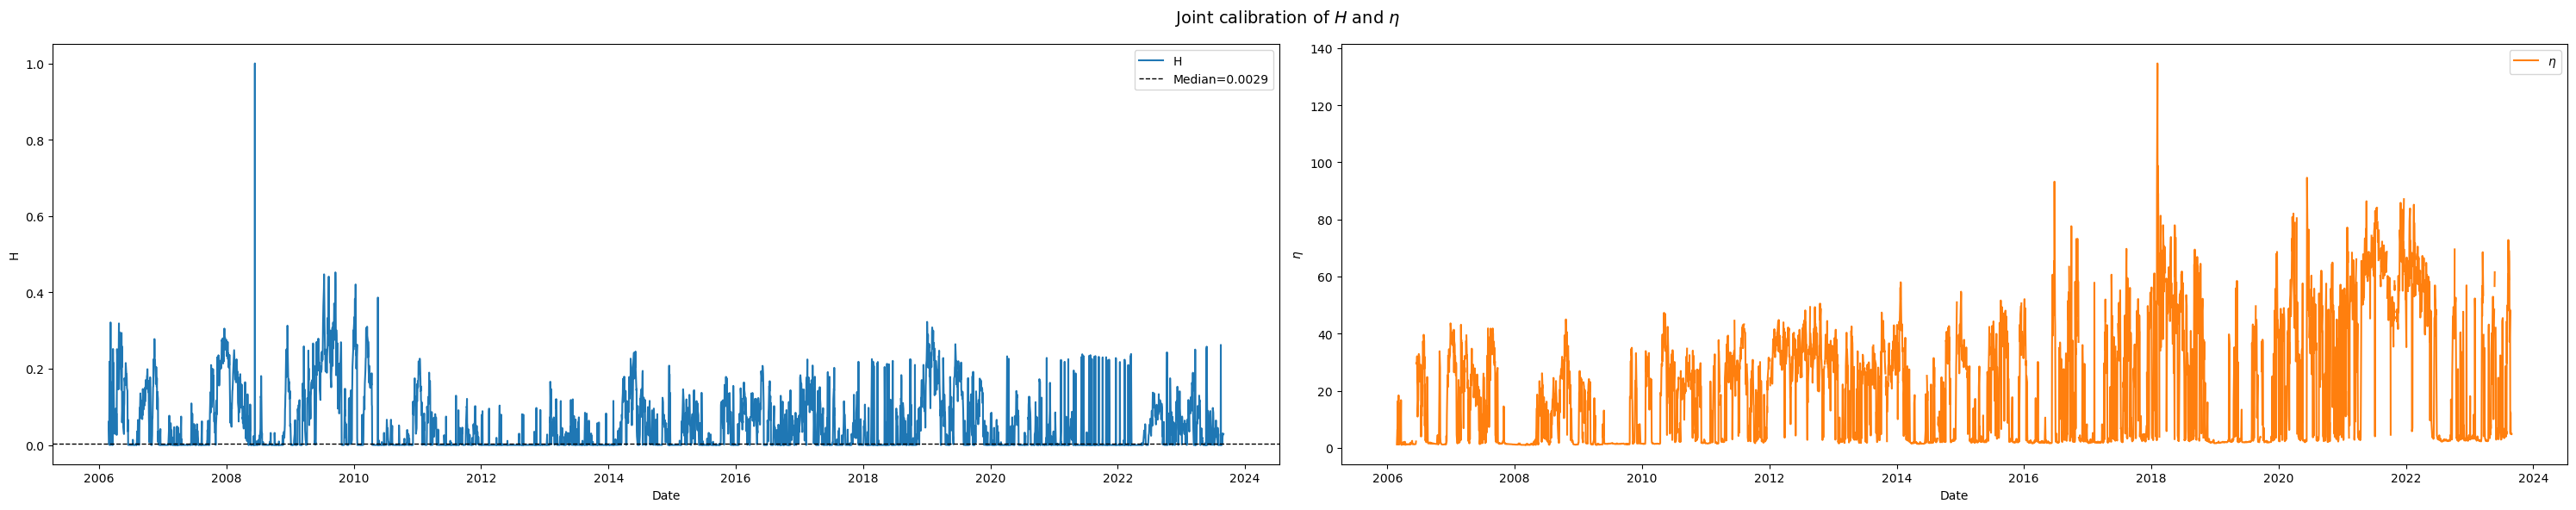

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

axs[0].plot(params['H'], label='H', color='C0')
axs[0].axhline(params['H'].median(), ls='--', color='black', lw=1, label=f'Median={params["H"].median():.4f}')
axs[1].plot(params['eta'], label=r'$\eta$', color='C1')
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")

fig.tight_layout()
plt.savefig(f"./Plots/calibrated_params_{start}_{end}.png")
plt.show()

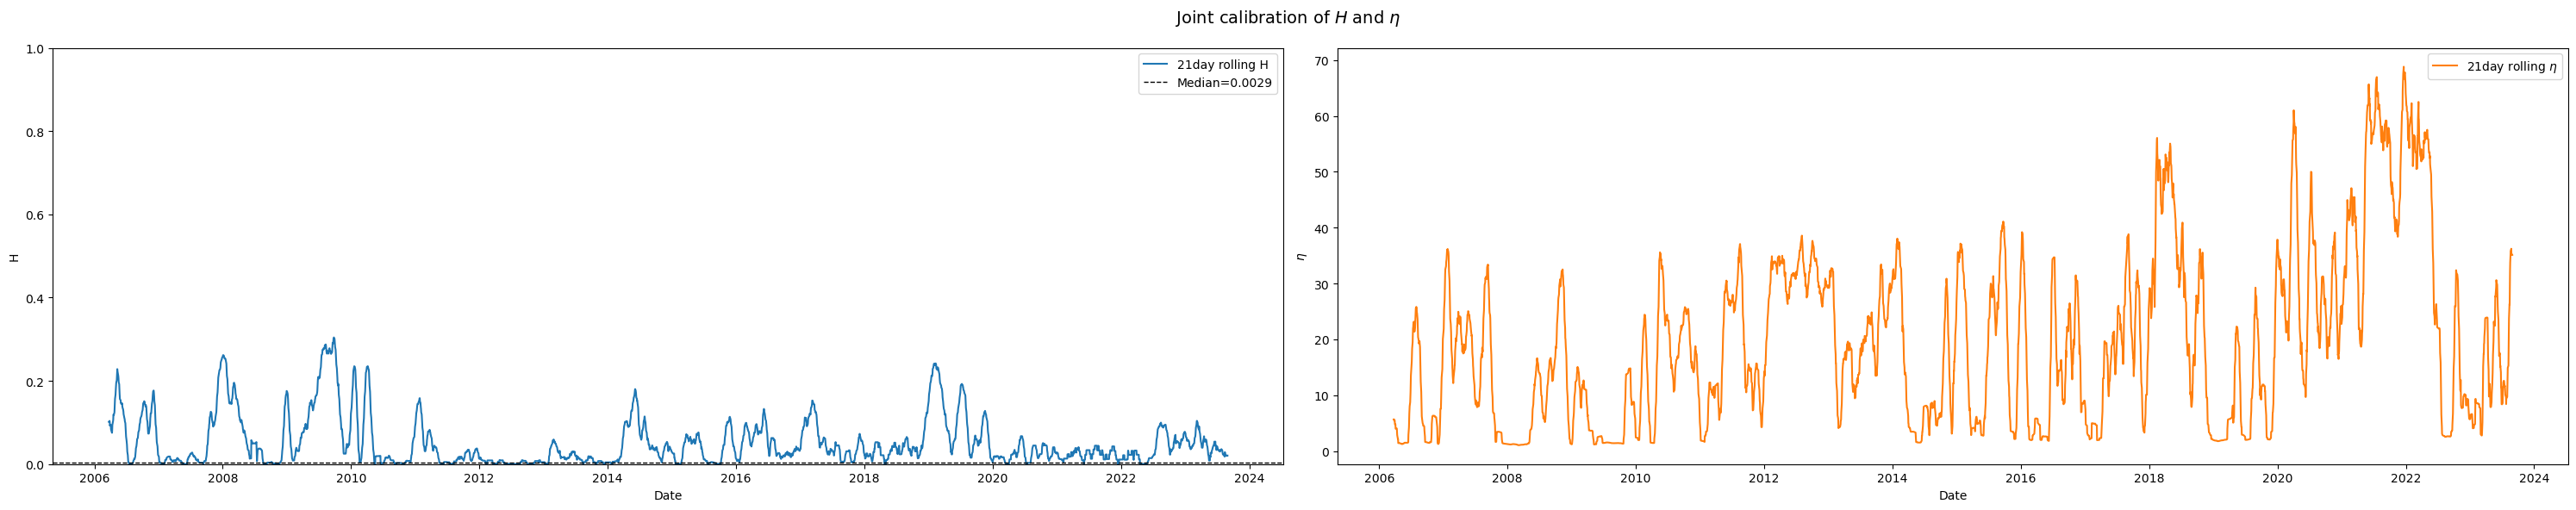

In [151]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
fig.suptitle(r"Joint calibration of $H$ and $\eta$", fontsize=14)

axs[0].plot(params['H'].rolling(21).mean(), label='21day rolling H', color='C0')
axs[0].axhline(params['H'].median(), ls='--', color='black', lw=1, label=f'Median={params["H"].median():.4f}')
axs[1].plot(params['eta'].fillna(1.9).rolling(21).mean(), label=r'21day rolling $\eta$', color='C1')
axs[0].set_ylabel("H"); axs[1].set_ylabel(r"$\eta$")
axs[0].set_ylim(0, 1)
for ax in axs:
    ax.legend()
    ax.set_xlabel("Date")

fig.tight_layout()
plt.show()

In [142]:
params.to_parquet(f"params_{start}_{end}.parquet")